In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from tabulate import tabulate
from astropy.time import Time
from tqdm import tqdm
import csv

In [22]:
def set_filter(file, start, stop, drift_max=0, snr_max=50, beam_val=2 ):
    # Load and slice dataset
    global df_new
    df = pd.read_pickle(f"/datag/users/ctremblay/{file}")
    print(df.columns)
    small_df = df[start:stop]

    # Select relevant columns
    columns = ['file_uri', 'observation_id','source_name', 'beam_id', 'ra_hours', 'dec_degrees', 'tstart',
               'signal_frequency', 'signal_beam', 'signal_drift_rate', 'signal_snr',
               'signal_power', 'signal_incoherent_power']
    df_new = small_df[columns]

    # Apply filtering thresholds
    df_new = df_new[(df_new['signal_drift_rate'] != drift_max) &
                    (df_new['signal_snr'] <= snr_max)]
    
    #print(f"Total filtered hits: {len(df_new)}")

    return df_new



In [23]:
#rfi filtering based on power ratio and overlapping frequency in fov 
def processing(file, start, stop):
    df_new = set_filter(file, start, stop)
    fov_group = df_new.groupby('file_uri')
    all_fov_dfs = []

    for file_uri, fov_df in fov_group:
        fov_df = fov_df.copy()  # avoid SettingWithCopyWarning
        fov_df['rfi_flag'] = False  # initialize all False

        

        # Flag overlapping frequencies at same tstart
        grouped_time = fov_df.groupby('tstart')
        overlap_indices = []
        for t_value, t_df in grouped_time:
            freq_counts = t_df['signal_frequency'].value_counts()
            overlapping_freqs = freq_counts[freq_counts > 1]
            for freq in overlapping_freqs.index:
                hits = t_df[t_df['signal_frequency'] == freq]
                overlap_indices.extend(hits.index.tolist())

        # Set rfi_flag True for overlapping hits
        fov_df.loc[overlap_indices, 'rfi_flag'] = True

        # Power ratio flagging of entire FOV if condition met
        for idx, row in fov_df.iterrows():
            incoh = row['signal_incoherent_power']
            coh = row['signal_power']
            if incoh > 0 and (coh / incoh) > 2.5:

                fov_df.at[idx, 'rfi_flag'] = True  # Flag only this hit

        all_fov_dfs.append(fov_df)
    full_df = pd.concat(all_fov_dfs, ignore_index=True)
    #print(full_df.groupby('rfi_flag').size())

    return full_df

#processing('Summer_Project_RA9_Dec0.90.pkl', 0, 1000000)


In [24]:
full_df = processing('Summer_Project_RA10_Dec0.2.pkl', 0, 1000000)
full_df.head()

Index(['id', 'beam_id', 'observation_id', 'tuning', 'subband_offset',
       'file_uri', 'file_local_enumeration', 'signal_frequency',
       'signal_index', 'signal_drift_steps', 'signal_drift_rate', 'signal_snr',
       'signal_coarse_channel', 'signal_beam', 'signal_num_timesteps',
       'signal_power', 'signal_incoherent_power', 'source_name', 'fch1_mhz',
       'foff_mhz', 'tstart', 'tsamp', 'ra_hours', 'dec_degrees',
       'telescope_id', 'num_timesteps', 'num_channels', 'coarse_channel',
       'start_channel'],
      dtype='object')


,file_uri,observation_id,source_name,beam_id,ra_hours,dec_degrees,tstart,signal_frequency,signal_beam,signal_drift_rate,signal_snr,signal_power,signal_incoherent_power,rfi_flag
0,/mnt/cosmic-storage-2/data2/K2-18b/23B-307.sb4...,13746,3910747531814692736,457029,11.504,7.58783,60239.60287,2339.741895,0,-29.588894,10.017949,7.461493e+11,4.863625e+11,True
1,/mnt/cosmic-storage-2/data2/K2-18b/23B-307.sb4...,13746,3910747531814692736,457029,11.504,7.58783,60239.60287,2339.734900,0,-27.891171,8.007792,6.401864e+11,4.717390e+11,False
2,/mnt/cosmic-storage-2/data2/K2-18b/23B-307.sb4...,13746,3910747531814692736,457029,11.504,7.58783,60239.60287,2339.732322,0,-22.798001,16.170870,1.070493e+12,8.357464e+11,True
3,/mnt/cosmic-storage-2/data2/K2-18b/23B-307.sb4...,13746,3910747531814692736,457029,11.504,7.58783,60239.60287,2339.746730,0,-12.611660,9.289216,7.077351e+11,3.479024e+11,False
4,/mnt/cosmic-storage-2/data2/K2-18b/23B-307.sb4...,13746,3910747531814692736,457029,11.504,7.58783,60239.60287,2339.718230,0,-5.578234,17.768711,1.154721e+12,5.774304e+11,True


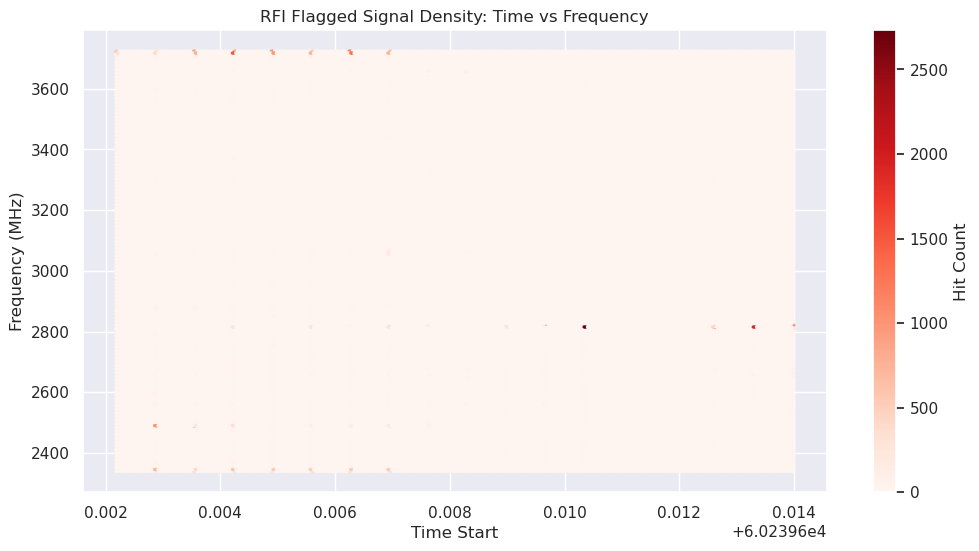

In [25]:
# signal density/ timevs freq
rfi_only = full_df[full_df['rfi_flag']==True]
plt.figure(figsize=(12, 6))
plt.hexbin(rfi_only['tstart'], rfi_only['signal_frequency'], gridsize=200, cmap='Reds')
plt.xlabel("Time Start")
plt.ylabel("Frequency (MHz)")
plt.title("RFI Flagged Signal Density: Time vs Frequency")
plt.colorbar(label='Hit Count')
plt.show()

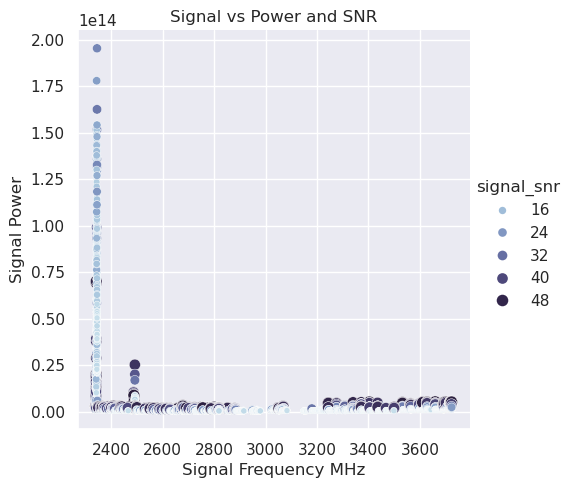

In [26]:
#visualize signal vs power with snr value incuded 
def pow_freq_snr(full_df):
    df_new = full_df
    sns.set_theme()
    sns.relplot(data=df_new, x=df_new["signal_frequency"], y=df_new["signal_power"], 
                hue=df_new["signal_snr"], size = df_new["signal_snr"], palette = "ch:s=.25,rot=-.25")
 
    plt.xlabel("Signal Frequency MHz")
    plt.ylabel("Signal Power")
    plt.title("Signal vs Power and SNR")
    plt.grid(True)
    plt.show()

pow_freq_snr(full_df)

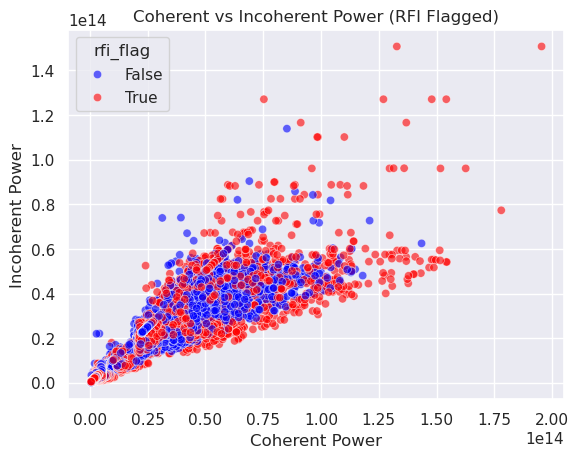

In [27]:
#visualize incoh to coh power with rfi flags included 
def pow_incoh_coh(full_df):
    df_new = full_df
    
    sns.scatterplot(
        data=df_new,
        x='signal_power',  # coherent
        y='signal_incoherent_power',
        hue='rfi_flag',
        palette={False: 'blue', True: 'red'},
        alpha=0.6
    )
    plt.xlabel("Coherent Power")
    plt.ylabel("Incoherent Power")
    plt.title("Coherent vs Incoherent Power (RFI Flagged)")
    plt.grid(True)
    plt.show()

pow_incoh_coh(full_df)

Excess Kurtosis: -1.2306448521694924
Skewness: 0.1963386337218205


/tmp/ipykernel_1122039/1143294128.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_rfi_df['power_ratio'] = non_rfi_df['signal_power'] / (non_rfi_df['signal_incoherent_power'] + 1e-9)


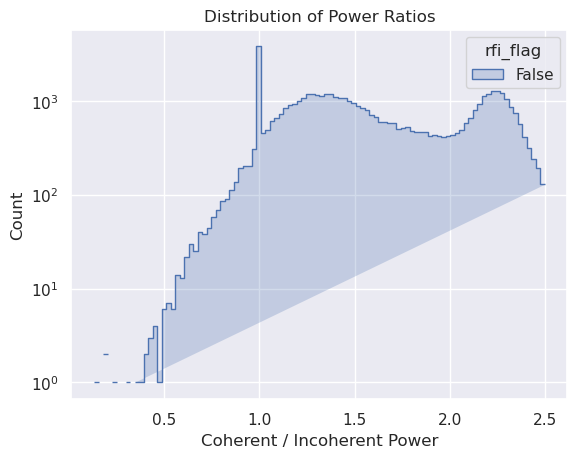

In [29]:
# visualize distribution of power ratios across data set/ time 
from scipy.stats import kurtosis, skew
non_rfi_df = full_df[full_df['rfi_flag'] == False]
ratios = non_rfi_df['signal_power'] / non_rfi_df['signal_incoherent_power']
ratios = ratios.replace([np.inf, -np.inf], np.nan).dropna()
print("Excess Kurtosis:", kurtosis(ratios, fisher=True))  # >0 = heavy tail
print("Skewness:", skew(ratios))

non_rfi_df['power_ratio'] = non_rfi_df['signal_power'] / (non_rfi_df['signal_incoherent_power'] + 1e-9)
sns.histplot(data=non_rfi_df, x='power_ratio', hue='rfi_flag', bins=100, log_scale=(False, True), element='step')  
plt.title("Distribution of Power Ratios")
plt.xlabel("Coherent / Incoherent Power")
plt.grid(True)
plt.show()

non_rfi_df.to_pickle('data/non_rfi_df.pkl')

#save in pickle file in scratch space 

In [9]:
#beam analysis 
full_df.groupby('signal_beam').size()

signal_beam
0    45648
1    45309
2    38375
3    34610
4    28059
5      530
dtype: int64

In [11]:
def processing(file,start,stop):
    df = pd.read_pickle(f"/datag/users/ctremblay/{file}")
    small_df = df[start:stop]
    columns=['source_name','beam_id','ra_hours' , 'dec_degrees' , 'tstart','signal_frequency', 'signal_beam', 
             'signal_drift_rate', 'signal_snr' , 'signal_power' , 'signal_incoherent_power']
    df_new= small_df[columns]
    #signal_drift_rate == 0 remove
    # S/R > 20 remove 
    grouped_dec = df_new.groupby("dec_degrees")

    dec_dfs={}
    for dec_value, group_df in grouped_dec:
        dec_dfs[dec_value] = group_df  # Save entire group DataFrame
        #print(len(group_df))
       # print(group_df.groupby("ra_hours").size())

    for i, (dec_value, df) in enumerate(dec_dfs.items(), start=1):
        globals()[f"fov_{i}"] = df
    print(len(fov_1))
    print(fov_1.groupby("tstart").size())

    return fov_1.head()
   # print(len(np.unique(df_new['signal_frequency'])))
   # print(df_new.groupby("tstart").size())
   # print(df_new.groupby("ra_hours").size())
   # print(df_new.groupby("signal_frequency").size())


    #return df_new

    

processing('Summer_Project_RA9_Dec0.177.pkl', 0,1000000)


10871
tstart
60533.645887    946
60533.645984    289
60533.646081    262
60533.646178    558
60533.646275    868
60533.646372    240
60533.646469    474
60533.646566    920
60533.646663    277
60533.646760    306
60533.646858    561
60533.646955    897
60533.647052    226
60533.647149    458
60533.647246    942
60533.647343    294
60533.647440    284
60533.647537    521
60533.647634    864
60533.647731    223
60533.647828    461
dtype: int64


,source_name,beam_id,ra_hours,dec_degrees,tstart,signal_frequency,signal_beam,signal_drift_rate,signal_snr,signal_power,signal_incoherent_power
38963,3834487260737663488,1206927,9.941742,1.246565,60533.646469,3178.211701,1,0.0,17.661158,3.814321e+12,3.753798e+12
38964,3834487260737663488,1206927,9.941742,1.246565,60533.646469,3178.240903,1,0.0,14.888799,3.343904e+12,3.098749e+12
38965,3834487260737663488,1206927,9.941742,1.246565,60533.646469,3178.267901,1,0.0,39.732716,7.559449e+12,7.345537e+12
38966,3834487260737663488,1206927,9.941742,1.246565,60533.646469,3178.326301,1,0.0,29.920475,5.894496e+12,5.773824e+12
38967,3834487260737663488,1206927,9.941742,1.246565,60533.646469,3178.355102,1,0.0,16.568609,3.628936e+12,3.355298e+12


In [12]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    uniqude_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        class_index = (labels == k).nonzero()[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    
    plt.tight_layout()
